In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import gamma as gamma_function
import math
import time

In [2]:
class Cuckoo():
    
    # Constant Parameters
    X_min = 0
    X_max = 100
    alpha_min = 0.9
    alpha_max = 1.0
    pa_min = 0.05
    pa_max = 0.25
    N_nest = 25          # total no. of solutions in the test field
    N_itertotal = 100    # max. no. of iterations for each node localization
    gamma = 0.1          # noise factor
    lamda = 1.5          # constant used in le'vy flight
    
    total_nodes = 0
    anchor_percent = 0
    t_range = 0          # transmission range
    
    X_anchor = []        # anchor list
    X_unknown = []       # unknown nodes list
    
    X_loc = []           # (estimated coords, actual coords) pairs
    F_mins = []          # iteration-wise optimum fitness values
    X_loc_test = []
    
    def __init__(self, total_nodes = 100, anchor_percent = 0.20, t_range = 25):
        self.total_nodes = total_nodes
        self.anchor_percent = anchor_percent
        self.t_range = t_range
        self.M = int(self.anchor_percent * self.total_nodes) # no. of anchor nodes
        self.N = self.total_nodes - self.M # no. of unknown nodes        
        
        # Anchor Deployment
        for i in range(self.M):
            x_anchor = np.random.randint(self.X_max)
            y_anchor = np.random.randint(self.X_max)
            self.X_anchor.append([x_anchor, y_anchor])
        
        # Unknown nodes Deployment
        for i in range(self.N):
            x_unknown = np.random.randint(self.X_max)
            y_unknown = np.random.randint(self.X_max)
            self.X_unknown.append([x_unknown, y_unknown])
        
        self.X_unknown = np.array(self.X_unknown)
        self.X_anchor = np.array(self.X_anchor)
    
        # Backup of original coordinates of Anchor and Unknown nodes
        self.X_anchor_og = self.X_anchor.copy()
        self.X_unknown_og = self.X_unknown.copy()
    
    
    def show_field(self, unk = True):
        """Plots the test field containing labeled nodes"""
        plt.figure(figsize=(8, 8))
        if unk == True:
            if len(self.X_unknown) != 0:
                plt.plot(self.X_unknown[:, 0], self.X_unknown[:, 1], 'yo', label="Left Node")
            plt.plot(self.X_unknown_og[:, 0], self.X_unknown_og[:, 1], 'ro', label='Unknown Node')
        else:
            plt.plot(self.X_unknown_og[:, 0], self.X_unknown_og[:, 1], 'ro', label='Unknown Node')
            if len(self.X_unknown) != 0:
                plt.plot(self.X_unknown[:, 0], self.X_unknown[:, 1], 'yo', label="Left Node")
        plt.plot(self.X_anchor_og[:, 0], self.X_anchor_og[:, 1], 'go', label="Anchor Node")
        plt.plot(self.X_anchor[self.M:, 0], self.X_anchor[self.M:, 1], 'b^', label="Localized Node", fillstyle='none', markersize=10)
        
        plt.legend()
        plt.axis([0,self.X_max,0,self.X_max])
        plt.grid()
        plt.show()
    
    
    def alpha(self, n_iter):
        """Step size used in Le'vy flight"""
        return self.alpha_max - ((n_iter/ self.N_itertotal) * (self.alpha_max - self.alpha_min)) # returns step size value

    def levy(self):
        """Returns random walk value"""
        temp = np.power(((gamma_function(1 + self.lamda) * np.sin(np.pi * (self.lamda /2))) / (gamma_function((1 + self.lamda)/2) * self.lamda * np.power(2, ((self.lamda - 1)/2)) )), 1/self.lamda)
        u = np.random.normal(0, temp)
        v = np.random.normal(0,1)
        r = u / (np.power(abs(v), (1/self.lamda)))

        return r  # random walk value

    
    def limiter(self, point):
        """Prevents the node from exiting the test field"""
        x = point[0]
        y = point[1]
        if x > self.X_max and y > self.X_max:
            x,y = self.X_max, self.X_max
        elif x > self.X_max and self.X_min < y < self.X_max:
            x,y = self.X_max, y
        elif x > self.X_max and y < self.X_min:
            x,y = self.X_max, self.X_min
        elif self.X_min < x < self.X_max and y < self.X_min:
            x,y = x, self.X_min
        elif x < self.X_min and y < self.X_min:
            x,y = self.X_min, self.X_min
        elif x < self.X_min and self.X_min < y < self.X_max:
            x,y = self.X_min, y
        elif x < self.X_min and y > self.X_max:
            x,y = self.X_min, self.X_max
        elif self.X_min < x < self.X_max and y > self.X_max:
            x,y = x, self.X_max

        return [x,y]

    
    def neighbours(self, node, anchors):
        """Returns a list of neighbouring anchor nodes within transmission range of the input node"""
        x = node[0]
        y = node[1]
        X_anchor = anchors
                
        l = []
        for j in range(len(X_anchor)): # for every anchor node in the list
            dist_real = np.power((np.power((x - X_anchor[j][0]), 2) + np.power((y - X_anchor[j][1]), 2)), 0.5)
            np.random.seed(2)
            dist_err = dist_real + np.random.normal(0, (self.gamma*dist_real))
            np.random.seed()
            

            if dist_err < self.t_range: # vicinity check
                l.append(X_anchor[j])
                
        return l # neighbouring anchors coordinates

    def objective(self, node, n_anchors, node_unknown, min_nodes = 3):
        """objective function (to minimize)"""
        x = node[0]
        y = node[1]
        
        x1 = node_unknown[0]
        y1 = node_unknown[1]
        
        l = self.neighbours(node_unknown, n_anchors) # calculating neighbours of the unknown node
        m = len(l)
        rerror = []
        if len(l) >= min_nodes:
            for ancn in l: 
                #dij
                dist_real = np.power((np.power((x - ancn[0]), 2) + np.power((y - ancn[1]), 2)), 0.5)
                
                #dij1
                dist_real1 = np.power((np.power((x1 - ancn[0]), 2) + np.power((y1 - ancn[1]), 2)), 0.5)
                
                #dij'
                np.random.seed(2)
                dist_err = dist_real1 + np.random.normal(0, (self.gamma*dist_real1))
                np.random.seed()
                rerror.append(np.power(dist_real - dist_err,2))

        # returning worst solutions (not enough neighbouring anchors) with infinite value
        ans = None
        if math.isnan(np.sum(rerror)/m): 
            ans = np.inf
        else:
            ans = np.sum(rerror)/m or None
            
        return ans # mean of square of ranging error

    
    def mod_cs(self, N_anchor, node_unknown, n_iter):
        """Enhanced Cuckoo Search Algorithm"""
        # Initial population (Random deployment of 'N' nests)
        X_nest = []
        min_nodes = len(N_anchor)
        for i in range(self.N_nest):
            x_nest = np.random.randint(self.X_max)
            y_nest = np.random.randint(self.X_max)
            X_nest.append([x_nest, y_nest])
        
        # Calculating fitness value of each nest
        Obj_X_nest = []
        for i in range(len(X_nest)):
            Obj_X_nest.append(self.objective(X_nest[i], N_anchor, node_unknown, min_nodes) or np.inf)
#         print(Obj_X_nest)
        
        N_iter = 0
        fmins = []
        self.N_itertotal = n_iter
        while(N_iter < self.N_itertotal): # fittest solution search loop
            N_iter += 1
            X_js = []
            Obj_X_js = []
            # applying Le'vy flight to every solution
            for i in range(len(X_nest)):
                X_j = X_nest[i].copy()
                X_j[0] = X_j[0] + self.alpha(N_iter) * self.levy()
                X_j[1] = X_j[1] + self.alpha(N_iter) * self.levy()
                
                X_j = self.limiter(X_j)
                
                F_j = self.objective(X_j, N_anchor, node_unknown, min_nodes) or np.inf
                
                rand_k = np.random.randint(0, len(X_nest))
                
                F_k = Obj_X_nest[rand_k]
                
                # comparing fitness of new solution with existing solution
                if F_j > F_k:
                    X_j[0] = X_nest[rand_k][0]
                    X_j[1] = X_nest[rand_k][1]
                    F_j = F_k

                X_js.append(X_j)
                Obj_X_js.append(F_j)
            
            # finding current best solution out of 'N' nests
            Obj_X_js = np.array([np.inf if i is None else i for i in Obj_X_js])
            F_min = Obj_X_js[np.argmin(Obj_X_js)]
#             print(F_min)
            current_best_sol = X_js[np.argmin(Obj_X_js)]
            
            # Calculation of mutation probability (Pa)
            Pa_j = []
            for i in Obj_X_js:
                K = i - F_min
                if K < 1:
                    Pa_j.append(self.pa_min + (self.pa_max - self.pa_min) * K)
                else:
                    Pa_j.append(self.pa_max / N_iter)

            # Mutation process
            for i in range(len(Pa_j)):
                rand_temp = np.random.uniform(0, 1)
                if rand_temp < Pa_j[i]:
                    my_x = np.random.randint(self.X_max)
                    my_y = np.random.randint(self.X_max)
                    F_my_xy = self.objective([my_x, my_y], N_anchor, node_unknown, min_nodes) or np.inf
                    if (Obj_X_js[i]) > (F_my_xy):
                        X_js[i] = [my_x, my_y]
                        Obj_X_js[i] = F_my_xy
            
            # finding the best solution of current iteration
            Obj_X_js = np.array([np.inf if i is None else i for i in Obj_X_js])
            F_min = Obj_X_js[np.argmin(Obj_X_js)]
#             print(F_min)
            self.F_mins.append(F_min)
            fmins.append(F_min)
        
#             self.X_loc_test.append([X_js[np.argmin(Obj_X_js)],node_unknown])
        
# #         Average Localization Error (ALE)
#             distances = []
#             for loc in self.X_loc_test:
#                 modified = loc[0]
#                 original = loc[1]

#                 distances.append(np.sqrt((modified[0] - original[0])**2 + (modified[1] - original[1])**2))

#             ale = np.sum(distances)/len(distances)
#             print('ALE = ', ale)
        
        
            
            # Early stopping mechanism
            if len(fmins) > 3:
#                 delta = 0.05
                d1 = abs(fmins[-1] - fmins[-2])
                d2 = abs(fmins[-2] - fmins[-3])
                d3 = abs(fmins[-3] - fmins[-4])
                if d1 == d2 == d3 == 0:
#                 if abs(d1 - d2) and abs(d2 - d3) and abs(d1 - d3) < delta:
#                     print('Exiting', N_iter)
#                     print('es1')
                    break
            
            # Obtaining the fittest coordinates of the iteration
            best_sol = X_js[np.argmin(Obj_X_js)]
            X_nest = X_js.copy()
            Obj_X_nest = Obj_X_js.copy()            
#         self.X_loc_test = []
#         print('unk1')
        return best_sol # returns global best estimated coordinates
                
    
    def update_Unknown(self, indexes):        
        """Updating Unknown List after localization"""
        # append the corresponding coordinates of the index values which are not localized in a list,
        #  and then update the unknown nodes' list
        X_unknown_temp = []
        for j in range(len(self.X_unknown)):
            if j in indexes:
                pass
            else:
                X_unknown_temp.append(self.X_unknown[j])

        self.X_unknown = np.array(X_unknown_temp)
        
    
    
    
    def main(self, n_iter):
        """Node Localization Process"""
        for j in range(5):
            localised_indexes = []
            for i in range(len(self.X_unknown)):
                nn = self.neighbours(self.X_unknown[i], self.X_anchor)
    #                 print(i, end="\r")
                if len(nn) >= 3:
                    updated_node_location = self.mod_cs(nn, self.X_unknown[i], n_iter)

                    self.X_loc.append([updated_node_location, self.X_unknown[i]])

                    # Updated 
                    X_anchor_temp = list(self.X_anchor)
                    X_anchor_temp.append(updated_node_location)
                    self.X_anchor = np.array(X_anchor_temp)

                    localised_indexes.append(i)

            self.update_Unknown(localised_indexes)
        
#         self.X_loc = []
        
    
    
    
    
    
    
    

# EXPERIMENT

In [3]:
coco = Cuckoo(total_nodes=300, anchor_percent=0.15, t_range=25)

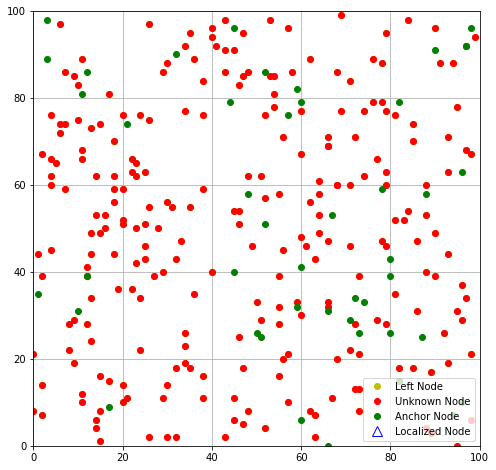

In [4]:
coco.show_field()

In [5]:
for i in range(5, 51, 5):
    coco.main(i)
    
#     coco.show_field()
    
    # Average Localization Error (ALE)
    distances = []
    for loc in coco.X_loc:
        modified = loc[0]
        original = loc[1]

        distances.append(np.sqrt((modified[0] - original[0])**2 + (modified[1] - original[1])**2))

    ale = np.sum(distances)/len(distances)
    print('ALE = ', ale)
    
    # Accumulated ALE (Acc. ALE)
    acc_ale = np.sum(distances)
    print('Acc. ALE = ', acc_ale)
    
    
    
    # Localization Success Ratio (LSR)
    lsr = (len(distances)/len(coco.X_unknown_og)) * 100
    print('LSR = ', lsr,'%')
    print('No.of localized nodes = ', len(distances))
    
    coco.X_loc = []
    coco.X_unknown = coco.X_unknown_og
    coco.X_anchor = coco.X_anchor_og
    

ALE =  5.779788746985917
Acc. ALE =  1473.8461304814086
LSR =  100.0 %
No.of localized nodes =  255
ALE =  2.4525162440976014
Acc. ALE =  625.3916422448883
LSR =  100.0 %
No.of localized nodes =  255
ALE =  1.0485219896611915
Acc. ALE =  267.3731073636038
LSR =  100.0 %
No.of localized nodes =  255
ALE =  0.7279977150165325
Acc. ALE =  185.6394173292158
LSR =  100.0 %
No.of localized nodes =  255
ALE =  0.7161319931386647
Acc. ALE =  182.6136582503595
LSR =  100.0 %
No.of localized nodes =  255
ALE =  0.593621657081841
Acc. ALE =  151.37352255586944
LSR =  100.0 %
No.of localized nodes =  255
ALE =  0.6231821359502591
Acc. ALE =  158.91144466731606
LSR =  100.0 %
No.of localized nodes =  255
ALE =  0.7424989467702949
Acc. ALE =  189.3372314264252
LSR =  100.0 %
No.of localized nodes =  255
ALE =  0.6748619572397909
Acc. ALE =  172.0897990961467
LSR =  100.0 %
No.of localized nodes =  255
ALE =  0.638708852387822
Acc. ALE =  162.87075735889462
LSR =  100.0 %
No.of localized nodes =  255

In [68]:
# start = time.time()
# coco.main()
# stop = time.time()

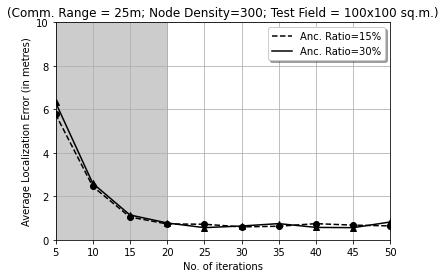

In [6]:
# ALE graph (No. of iterations)
# T_Range = const.

n_iter = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
ale_15 = [5.779788747,
2.452516244,
1.04852199,
0.727997715,
0.7161319931,
0.5936216571,
0.623182136,
0.7424989468,
0.6748619572,
0.6387088524]
ale_30 = [6.318946191,
2.595153504,
1.141333774,
0.7746695501,
0.5590284961,
0.634351556,
0.7442743487,
0.5701722903,
0.5584403101,
0.8197668047]

plt.xlabel("No. of iterations")
plt.ylabel("Average Localization Error (in metres)")
plt.title("(Comm. Range = 25m; Node Density=300; Test Field = 100x100 sq.m.)")

plt.plot(n_iter, ale_15, 'k--', label="Anc. Ratio=15%")
plt.plot(n_iter, ale_15, 'ko')
plt.plot(n_iter, ale_30, 'k', label="Anc. Ratio=30%")
plt.plot(n_iter, ale_30, 'k^')

plt.axvspan(5, 20, alpha=0.2, color='k')

plt.legend(shadow='true')
plt.axis([5,50,0,10])
plt.grid()
# plt.savefig('ecs-ale-anc.png', dpi=300, bbox_inches='tight')
plt.show()

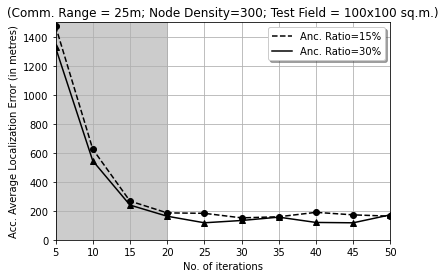

In [7]:
# Acc. ALE graph (No. of iterations)
# T_Range = const.

n_iter = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
acc_ale_15 = [1473.84613,
625.3916422,
267.3731074,
185.6394173,
182.6136583,
151.3735226,
158.9114447,
189.3372314,
172.0897991,
162.8707574]
acc_ale_30 = [1326.9787,
544.9822357,
239.6800925,
162.6806055,
117.3959842,
133.2138268,
156.2976132,
119.736181,
117.2724651,
172.151029]

plt.xlabel("No. of iterations")
plt.ylabel("Acc. Average Localization Error (in metres)")
plt.title("(Comm. Range = 25m; Node Density=300; Test Field = 100x100 sq.m.)")

plt.plot(n_iter, acc_ale_15, 'k--', label="Anc. Ratio=15%")
plt.plot(n_iter, acc_ale_15, 'ko')
plt.plot(n_iter, acc_ale_30, 'k', label="Anc. Ratio=30%")
plt.plot(n_iter, acc_ale_30, 'k^')

plt.axvspan(5, 20, alpha=0.2, color='k')

plt.legend(shadow='true')
plt.axis([5,50,0,1500])
plt.grid()
# plt.savefig('ecs-ale-anc.png', dpi=300, bbox_inches='tight')
plt.show()